In [1]:
# From POT (https://pythonot.github.io/auto_examples/gaussian_gmm/plot_GMM_flow.html#sphx-glr-auto-examples-gaussian-gmm-plot-gmm-flow-py)
# Author: Eloi Tanguy <eloi.tanguy@math.cnrs.fr>
#         Remi Flamary <remi.flamary@polytehnique.edu>
#         Julie Delon <julie.delon@math.cnrs.fr>
#
# License: MIT License

# sphinx_gallery_thumbnail_number = 4

import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

from matplotlib import colormaps as cm
import ot
import ot.plot
from ot.utils import proj_SDP, proj_simplex
from ot.gmm import gmm_ot_loss
import torch
from torch.optim import Adam
from matplotlib.patches import Ellipse

/home/clement/anaconda3/envs/py311/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


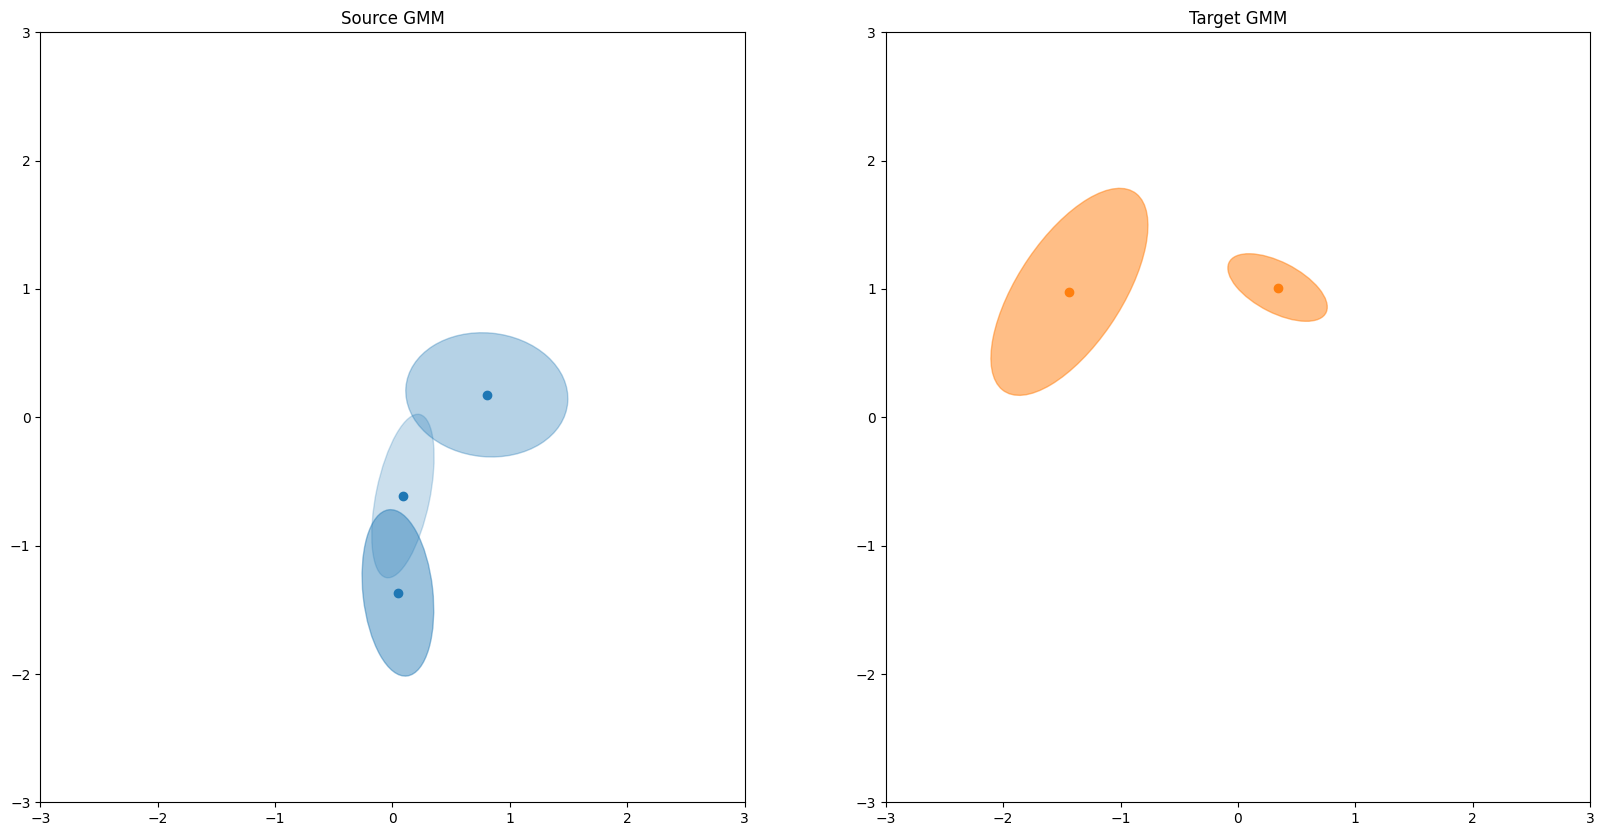

In [2]:
torch.manual_seed(3)
ks = 3
kt = 2
d = 2
eps = 0.1
m_s = torch.randn(ks, d)
# m_s.requires_grad_()
m_t = torch.randn(kt, d)
C_s = torch.randn(ks, d, d)
C_s = torch.matmul(C_s, torch.transpose(C_s, 2, 1))
C_s += eps * torch.eye(d)[None, :, :] * torch.ones(ks, 1, 1)
# C_s.requires_grad_()
C_t = torch.randn(kt, d, d)
C_t = torch.matmul(C_t, torch.transpose(C_t, 2, 1))
C_t += eps * torch.eye(d)[None, :, :] * torch.ones(kt, 1, 1)
w_s = torch.randn(ks)
w_s = proj_simplex(w_s)
# w_s.requires_grad_()
w_t = torch.tensor(ot.unif(kt))


def draw_cov(mu, C, color=None, label=None, nstd=1, alpha=0.5, ax=None):
    def eigsorted(cov):
        if torch.is_tensor(cov):
            cov = cov.detach().numpy()
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1].copy()
        return vals[order], vecs[:, order]

    vals, vecs = eigsorted(C)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(
        xy=(mu[0], mu[1]),
        width=w,
        height=h,
        alpha=alpha,
        angle=theta,
        facecolor=color,
        edgecolor=color,
        label=label,
        fill=True,
    )

    if ax is None:
        ax = plt.gca()
    
    # pl.gca().add_artist(ell)
    ax.add_patch(ell)


def draw_gmm(ms, Cs, ws, color=None, nstd=0.5, alpha=1, ax=None):
    for k in range(ms.shape[0]):
        draw_cov(ms[k], Cs[k], color, None, nstd, alpha * ws[k], ax=ax)


axis = [-3, 3, -3, 3]
plt.figure(1, (20, 10))

plt.subplot(1, 2, 1)
plt.scatter(m_s[:, 0].detach(), m_s[:, 1].detach(), color="C0")
draw_gmm(m_s.detach(), C_s.detach(), torch.softmax(w_s, 0).detach().numpy(), color="C0")
plt.axis(axis)
plt.title("Source GMM")

plt.subplot(1, 2, 2)
plt.scatter(m_t[:, 0].detach(), m_t[:, 1].detach(), color="C1")
draw_gmm(m_t.detach(), C_t.detach(), w_t.numpy(), color="C1")
plt.axis(axis)
plt.title("Target GMM")
plt.show()

In [3]:
import sys

from tqdm import trange

import sliced_mw as SMW

from GMM_utils import GaussianMixtureModel
from sliced_busemann_gaussian1d import sliced_1Dbusemann_GMM

sys.path.append("../")
from lib_torch.sliced_busemann_gaussian import busemann_sliced_gaussian


def gmm_flow(m_s, C_s, w_s, m_t, C_t, w_t, dist="gmmot", n_gd_its=100, lr=3e-2, n_projs=500, plot_loss=False):
    m_s = torch.clone(m_s).requires_grad_(True)
    C_s = torch.clone(C_s).requires_grad_(True)
    w_s = torch.clone(w_s).requires_grad_(True)
    
    opt = Adam(
        [
            {"params": m_s, "lr": 2 * lr},
            {"params": C_s, "lr": lr},
            {"params": w_s, "lr": lr},
        ]
    )
    m_list = [m_s.data.numpy().copy()]
    C_list = [C_s.data.numpy().copy()]
    w_list = [torch.softmax(w_s, 0).data.numpy().copy()]
    loss_list = []

    pbar = trange(n_gd_its)
    for _ in pbar:
        opt.zero_grad()

        if dist == "gmmot":
            loss = gmm_ot_loss(m_s, m_t, C_s, C_t, torch.softmax(w_s, 0), w_t)
        elif dist == "swm":
            gmm_dict_src = GaussianMixtureModel(torch.softmax(w_s, 0), m_s, C_s)
            gmm_dict_tgt = GaussianMixtureModel(w_t, m_t, C_t)
            loss = SMW.calc_parallel_SMSW(gmm_dict_src, gmm_dict_tgt, pnum=n_projs)
        elif dist == "swbg":
            loss = busemann_sliced_gaussian(m_s, m_t, C_s, C_t, n_projs, torch.softmax(w_s, 0), w_t)
        elif dist == "swbdg":
            loss = sliced_1Dbusemann_GMM(m_s, m_t, C_s, C_t, n_projs, u_weights=torch.softmax(w_s, 0), v_weights=w_t)

        loss.backward()
        opt.step()

        with torch.no_grad():
            C_s.data = proj_SDP(C_s.data, vmin=1e-6)
            m_list.append(m_s.data.numpy().copy())
            C_list.append(C_s.data.numpy().copy())
            w_list.append(torch.softmax(w_s, 0).data.numpy().copy())
            loss_list.append(loss.item())

    if plot_loss:
        plt.plot(loss_list)
        plt.title("Loss")
        plt.xlabel("its")
        plt.ylabel("loss")
        plt.show()

    return m_list, C_list, w_list


def plot_gmms(m_list, C_list, w_list, n_steps_visu=100, n_gd_its=100, ax=None):
    def index_to_color(i):
        return int(i**0.5)

    if ax is None:
        ax = plt
    
    its_to_show = [int(x) for x in np.linspace(1, n_gd_its - 1, n_steps_visu)]
    cmp = cm["plasma"].resampled(index_to_color(n_steps_visu))
    
    ax.scatter(
        m_list[0][:, 0], m_list[0][:, 1], color=cmp(index_to_color(0)), label="Source"
    )
    draw_gmm(m_list[0], C_list[0], w_list[0], color=cmp(index_to_color(0)), ax=ax)
    
    ax.scatter(
        m_t[:, 0].detach(),
        m_t[:, 1].detach(),
        color=cmp(index_to_color(n_steps_visu - 1)),
        label="Target",
    )

    draw_gmm(
        m_t.detach(), C_t.detach(), w_t.numpy(), color=cmp(index_to_color(n_steps_visu - 1)), ax=ax
    )
    
    
    for k in its_to_show:
        ax.scatter(
            m_list[k][:, 0], m_list[k][:, 1], color=cmp(index_to_color(k)), alpha=0.8
        )
        draw_gmm(m_list[k], C_list[k], w_list[0], color=cmp(index_to_color(k)), alpha=0.04, ax=ax)
    
    ax.axis(axis)

  0%|                                                                                                                                                                                      | 0/100 [00:00<?, ?it/s]/home/clement/anaconda3/envs/py311/lib/python3.11/site-packages/ot/lp/solver_1d.py:46: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  idx = nx.searchsorted(cws, qs).T
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 96.28it/s]


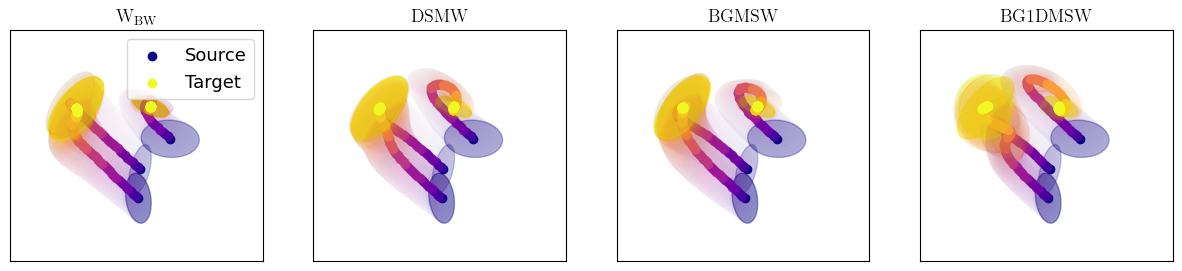

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(15,3))

labels = ["\mathrm{W}_{\mathrm{BW}}", "\mathrm{DSMW}", "\mathrm{BGMSW}", "\mathrm{BG1DMSW}"]

for i, dist in enumerate(["gmmot", "swm", "swbg", "swbdg"]):
    m_list, C_list, w_list = gmm_flow(m_s, C_s, w_s, m_t, C_t, w_t, dist=dist, n_projs=1000)
    plot_gmms(m_list, C_list, w_list, ax=ax[i])

    if i == 0:
        ax[i].legend(fontsize=13, loc="upper right")

    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_title(r"$"+str(labels[i])+"$", usetex=True, fontsize=13)

plt.savefig("Flow_GMMs.pdf", format="pdf", bbox_inches="tight")   # best for LaTeX
plt.show()